## Podstawy reprezentacji i analizy danych projekt zaliczeniowy
Autorzy: **Artur Arciszewski** i **Kamil Gomuła**\
Data: 27.01.2026\
Nazwa zbioru: Air Quality and Pollution Assessment\
Zadania: przeanalizowanie danych i stworzenie modelu klasyfikacji jakości powietrza

## Opis zbioru

Dane zostały pobrane ze strony [kaggle](https://www.kaggle.com/datasets/mujtabamatin/air-quality-and-pollution-assessment) 
Zbiór danych zawiera informacje na temat różnych parametrów powietrza wraz z informacjami o regionach a także przydzieloną kategorię jakości powietrza

- Temperature (°C): Średnia temperatura w regionie
- Humidity (%): względna wilgoć powietrza w regionie
- PM2.5 Concentration (µg/m³): stężenie pyłów zawieszonych.
- PM10 Concentration (µg/m³): stężenie grubych pyłów zawieszonych.
- NO2 Concentration (ppb): poziom dwutlenku azotu.
- SO2 Concentration (ppb): poziom dwutlenku siarki.
- CO Concentration (ppm): poziom tlenku węgla.
- Proximity to Industrial Areas (km): dystans do najbliższej strefy przemysłowej.
- Population Density (people/km²): ilość ludzi na kilometr kwadratowy.
- Zmienna docelowa: Air Quality Levels
  -  Good: czyste powietrze z niskim poziomem zanieczyszczenia.
  -  Moderate: Dopuszczalna jakość powietrza, ale obecne są pewne zanieczyszczenia.
  -  Poor: Zauważalne zanieczyszczenie, które może powodować problemy zdrowotne u grup wrażliwych.
  -  Hazardous: Silnie zanieczyszczone powietrze stwarza poważne zagrożenie dla zdrowia ludności.

In [1]:
# importy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestCentroid

In [2]:
# pobieranie danych
data = pd.read_csv('./data.csv')

## Analiza poprawności danych

In [3]:
print("ilość brakujących danych: ", end="")
print(data.isna().sum().sum())
dataDesc = data.describe()
dataDesc

ilość brakujących danych: 0


Temperature     Humidity        PM2.5         PM10          NO2  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean     30.029020    70.056120    20.142140    30.218360    26.412100   
std       6.720661    15.863577    24.554546    27.349199     8.895356   
min      13.400000    36.000000     0.000000    -0.200000     7.400000   
25%      25.100000    58.300000     4.600000    12.300000    20.100000   
50%      29.000000    69.800000    12.000000    21.700000    25.300000   
75%      34.000000    80.300000    26.100000    38.100000    31.900000   
max      58.600000   128.100000   295.000000   315.800000    64.900000   

               SO2           CO  Proximity_to_Industrial_Areas  \
count  5000.000000  5000.000000                    5000.000000   
mean     10.014820     1.500354                       8.425400   
std       6.750303     0.546027                       3.610944   
min      -6.200000     0.650000                       2.500000   
25%       5.100000     1.030000                       5.400000   
50%       8.000000     1.410000                       7.900000   
75%      13.725000     1.840000                      11.100000   
max      44.900000     3.720000                      25.800000   

       Population_Density  
count         5000.000000  
mean           497.423800  
std            152.754084  
min            188.000000  
25%            381.000000  
50%            494.000000  
75%            600.000000  
max            957.000000

Dane wyglądają na kompletne:
* ilość rekordów 5000
* brak wartości NaN w tabeli
* średnie wartości parametrów mieszczą się w oczekiwanych zakresach. Np. średnia temperatura około 30 stopni

Można zauważyć pewne anomalie dotyczące wartości niektórych atrybutów:
* minimalny poziom stężenia PM10 < 0
* minimalny poziom stężenia SO2 < 0

Przyjmujemy że ujemne wartości to efekt błędu pomiarowego

In [4]:
#mierzenie ilości niepoprawnych danych
print( (data["PM10"] < 0).sum() )
print( (data["SO2"] < 0).sum() )

1
30


Ilość błędnych danych jest marginalna. Ustawiamy ujemne wartości na 0.

In [5]:
# pozbycie się nieprawidłowych danych
data.loc[data["PM10"] < 0, "PM10"] = 0
data.loc[data["SO2"] < 0, "SO2"] = 0

### Sprawdzanie ilości poszczególnych klas

In [6]:
data["Air Quality"].value_counts()

Air Quality
Good         2000
Moderate     1500
Poor         1000
Hazardous     500
Name: count, dtype: int64

Z powyższej tabeli wynika że gorsza jakość powietrza rzadziej występuje w zbiorze. Nierówna dystrybucja klas może, ale nie musi być problemem przy tworzeniu klasyfikatora

## Wizualizacja atrybutów

### Histogramy

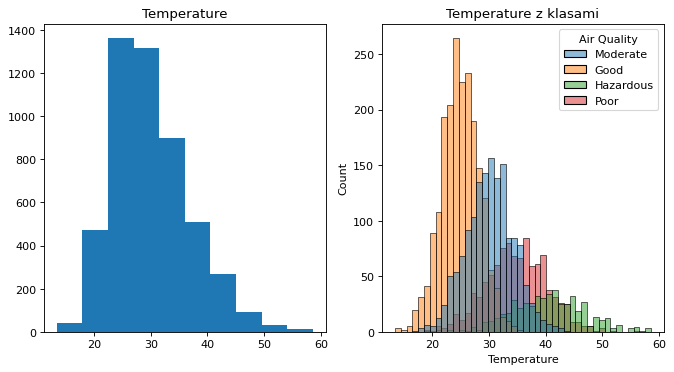

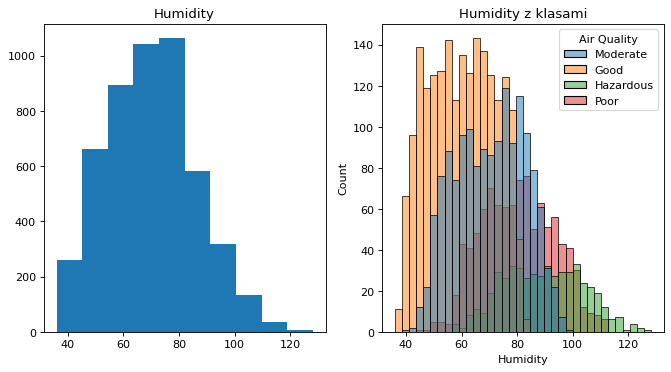

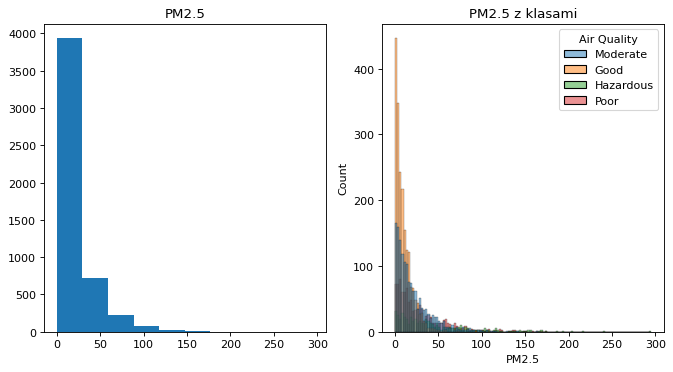

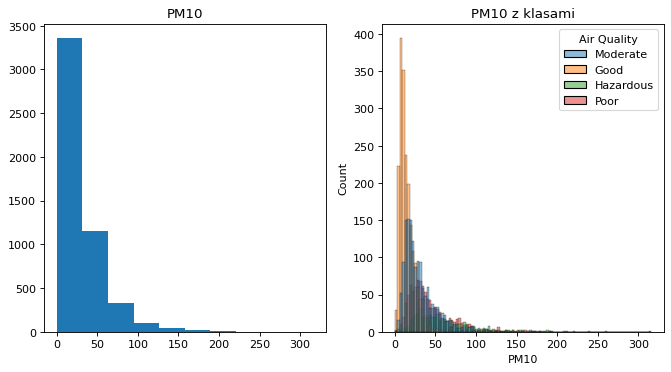

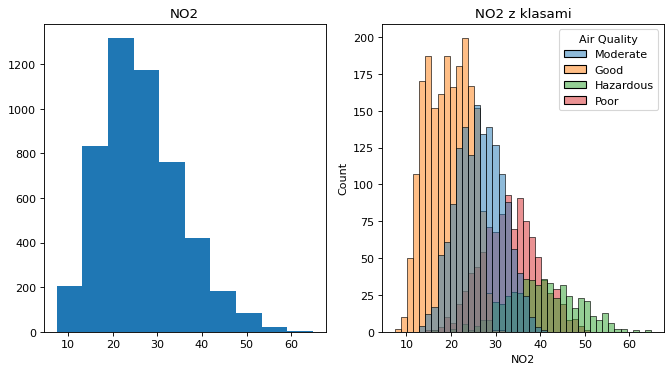

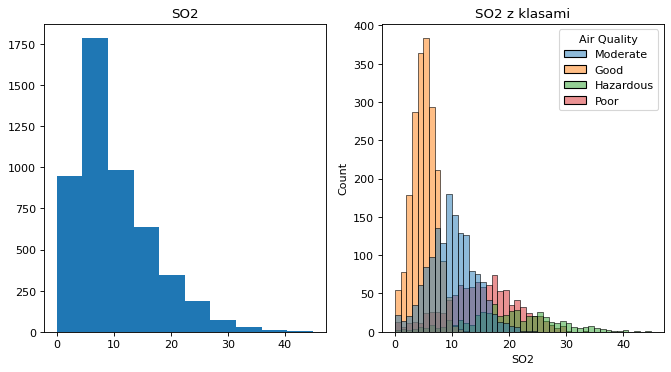

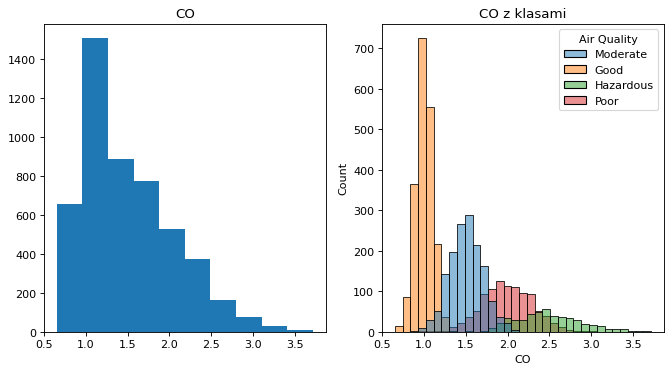

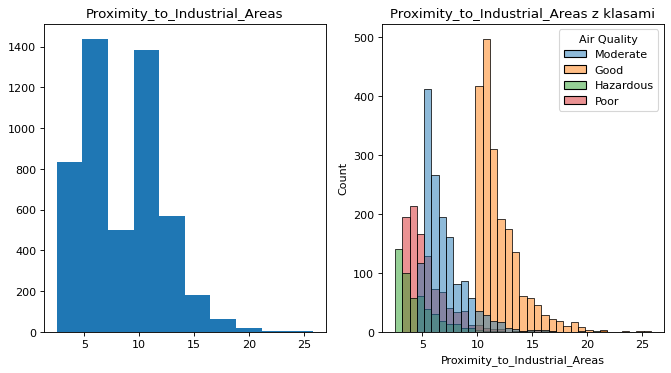

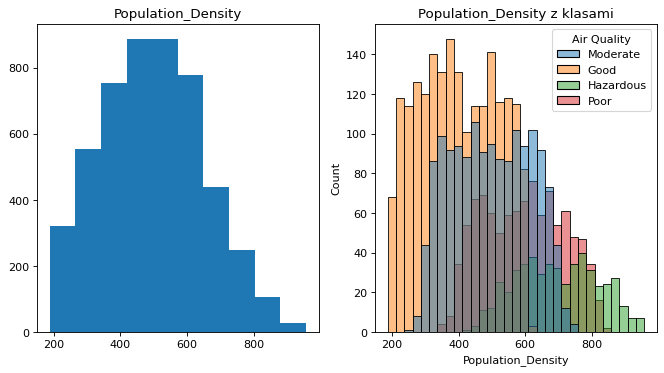

In [7]:
for i in range(0, data.shape[1]-1):
    plt.figure(figsize=(10,5), dpi= 80)
    
    plt.subplot(1,2,1)
    plt.title(data.columns[i])
    plt.hist(data.iloc[:,i])
    
    plt.subplot(1,2,2)
    plt.title(data.columns[i] + " z klasami")
    sns.histplot(data=data, x=data.columns[i], hue="Air Quality")

#### Wnioski do histogramów
Dla atrybutów: temperatura, wilgotność, NO2, SO2, CO, gęstość zaludnienia; dane w obrębie jednej klasy przyjmują kształt rozkładu normalnego oraz ich średnie wyraźnie się różnią. Taki rozkład jest korzystny dla klasyfikatorów typu *naiwny klasyfikator Bayesa* lub *metody najbliższego prototypu*.\
Dla atrybutu CO jest silnie wyróżniona klasa *Good* co czyni ten atrybut bardzo przydatnym do klasyfikacji.\
Dla atrybutu *Proximity to Industrial Areas* widzimy ogromy spadek występowania określonych jakości powietrza np. jakość *good* ma duże zagęszczenie dla 10-12km a dla 9km w ogóle nie występuje. Taka wyraźna granica powinna być przydatna przy klasyfikatorze *drzewa decyzyjnego*.\
Natomiast zarówno atrybuty PM2.5 i PM10 charateryzują się wysokim zagęszczeniem danych na początku wykresu oraz bardzo słabą rozróżnialnością miedzy klasami. Z powodu tych włąściwości wydają się być średnio przydatne do klasyfikacji

### Wykresy pudełkowe

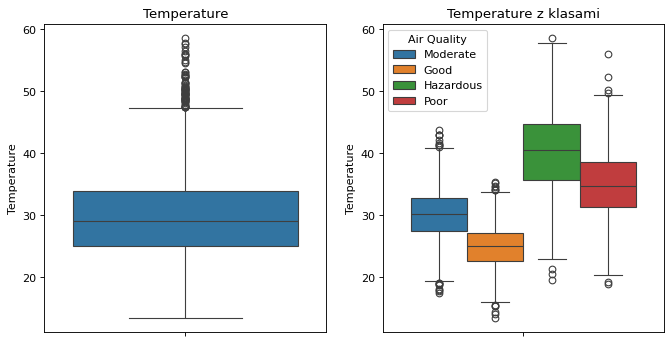

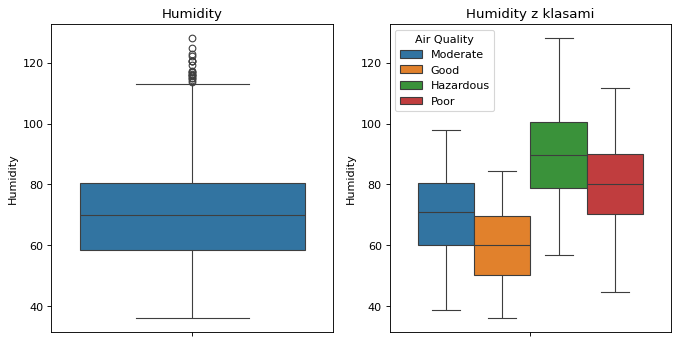

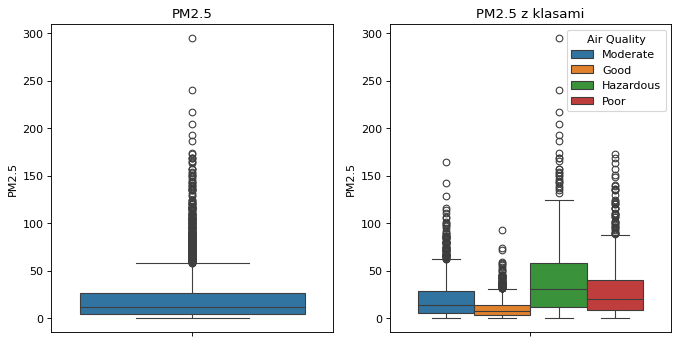

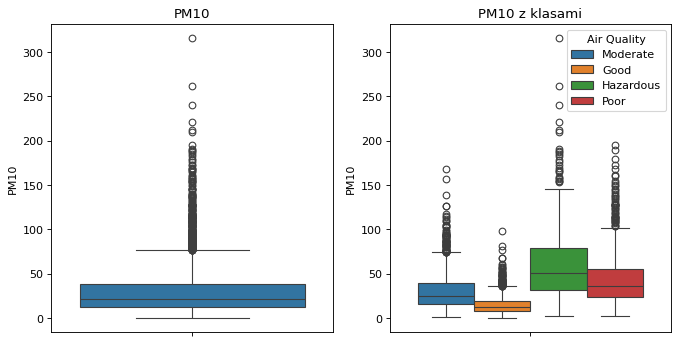

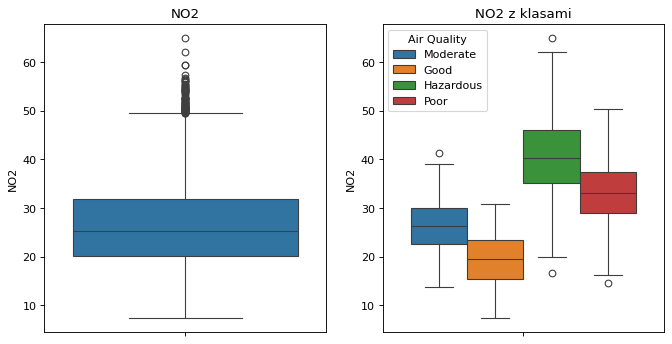

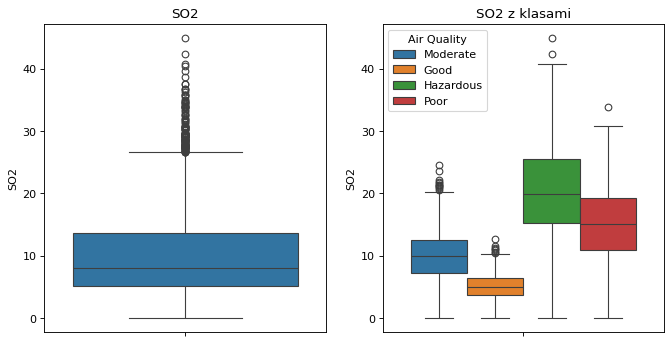

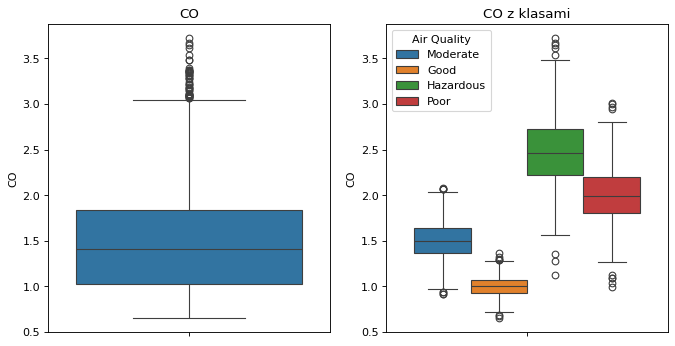

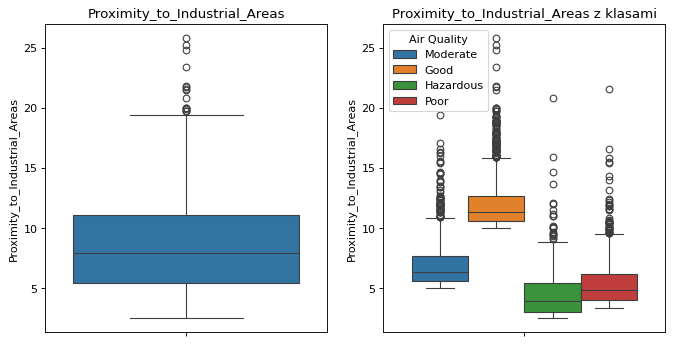

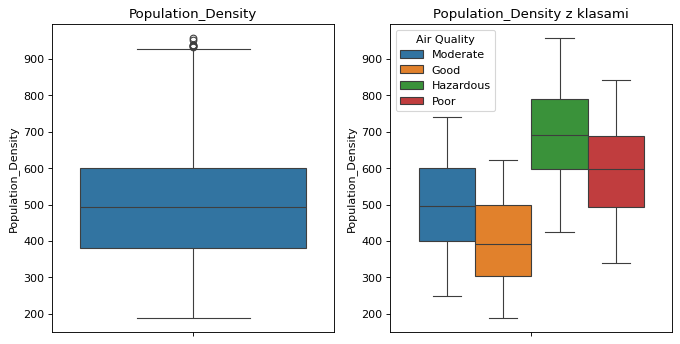

In [8]:
for i in range(0, data.shape[1]-1):
    plt.figure(figsize=(10,5), dpi= 80)

    plt.subplot(1,2,1)
    plt.title(data.columns[i])
    sns.boxplot(data=data.iloc[:,:-1], y=data.columns[i])
    
    plt.subplot(1,2,2)
    plt.title(data.columns[i] + " z klasami")
    sns.boxplot(data=data, y=data.columns[i], hue="Air Quality")
    


#### Wnioski to wykresu pudełkowego
Na wszystkich wykresach bez podziału na grupy możemy zaobserwować dużą liczbę wartości odstających. Prawdopodobnie jest to efekt traktowania wszystkich klas jako jedno.\
Patrząc na wykresy pudełkowe możemy wywnioskować że:
* Przy temperaturze widzimy wyraźne rozróżnienie między klasami
* Przy Wilgotnośći istnieje rozróżnienie ale jest one słabsze niż przy temperaturze
* PM2.5 i PM10 są bardzo spłaszczone do spodu wykresu a klasy są niezbyt rozróżnialne
* W NO2 klasy są bardzo ładnie oddzielone
* W SO2 klasa Good jest wyjątkowo spiczasta
* Przy CO pokrycie między klasami jest niewielkie co czyni ten atrybut przydatny do klasyfikacji
* Przy *Proximity to Industrial Areas* pokazuje dużo outlayerów co jest związanie z trójkątnym rozkładem tych danych.
* Oraz klasa Good jest dobrze odróżnialna od pozostałych klas
* Natomiast w *Population_Density* nie ma outlayerów oraz dane mają duży stopień pokrycia między klasami

### Pairplot

<Figure size 800x800 with 0 Axes>

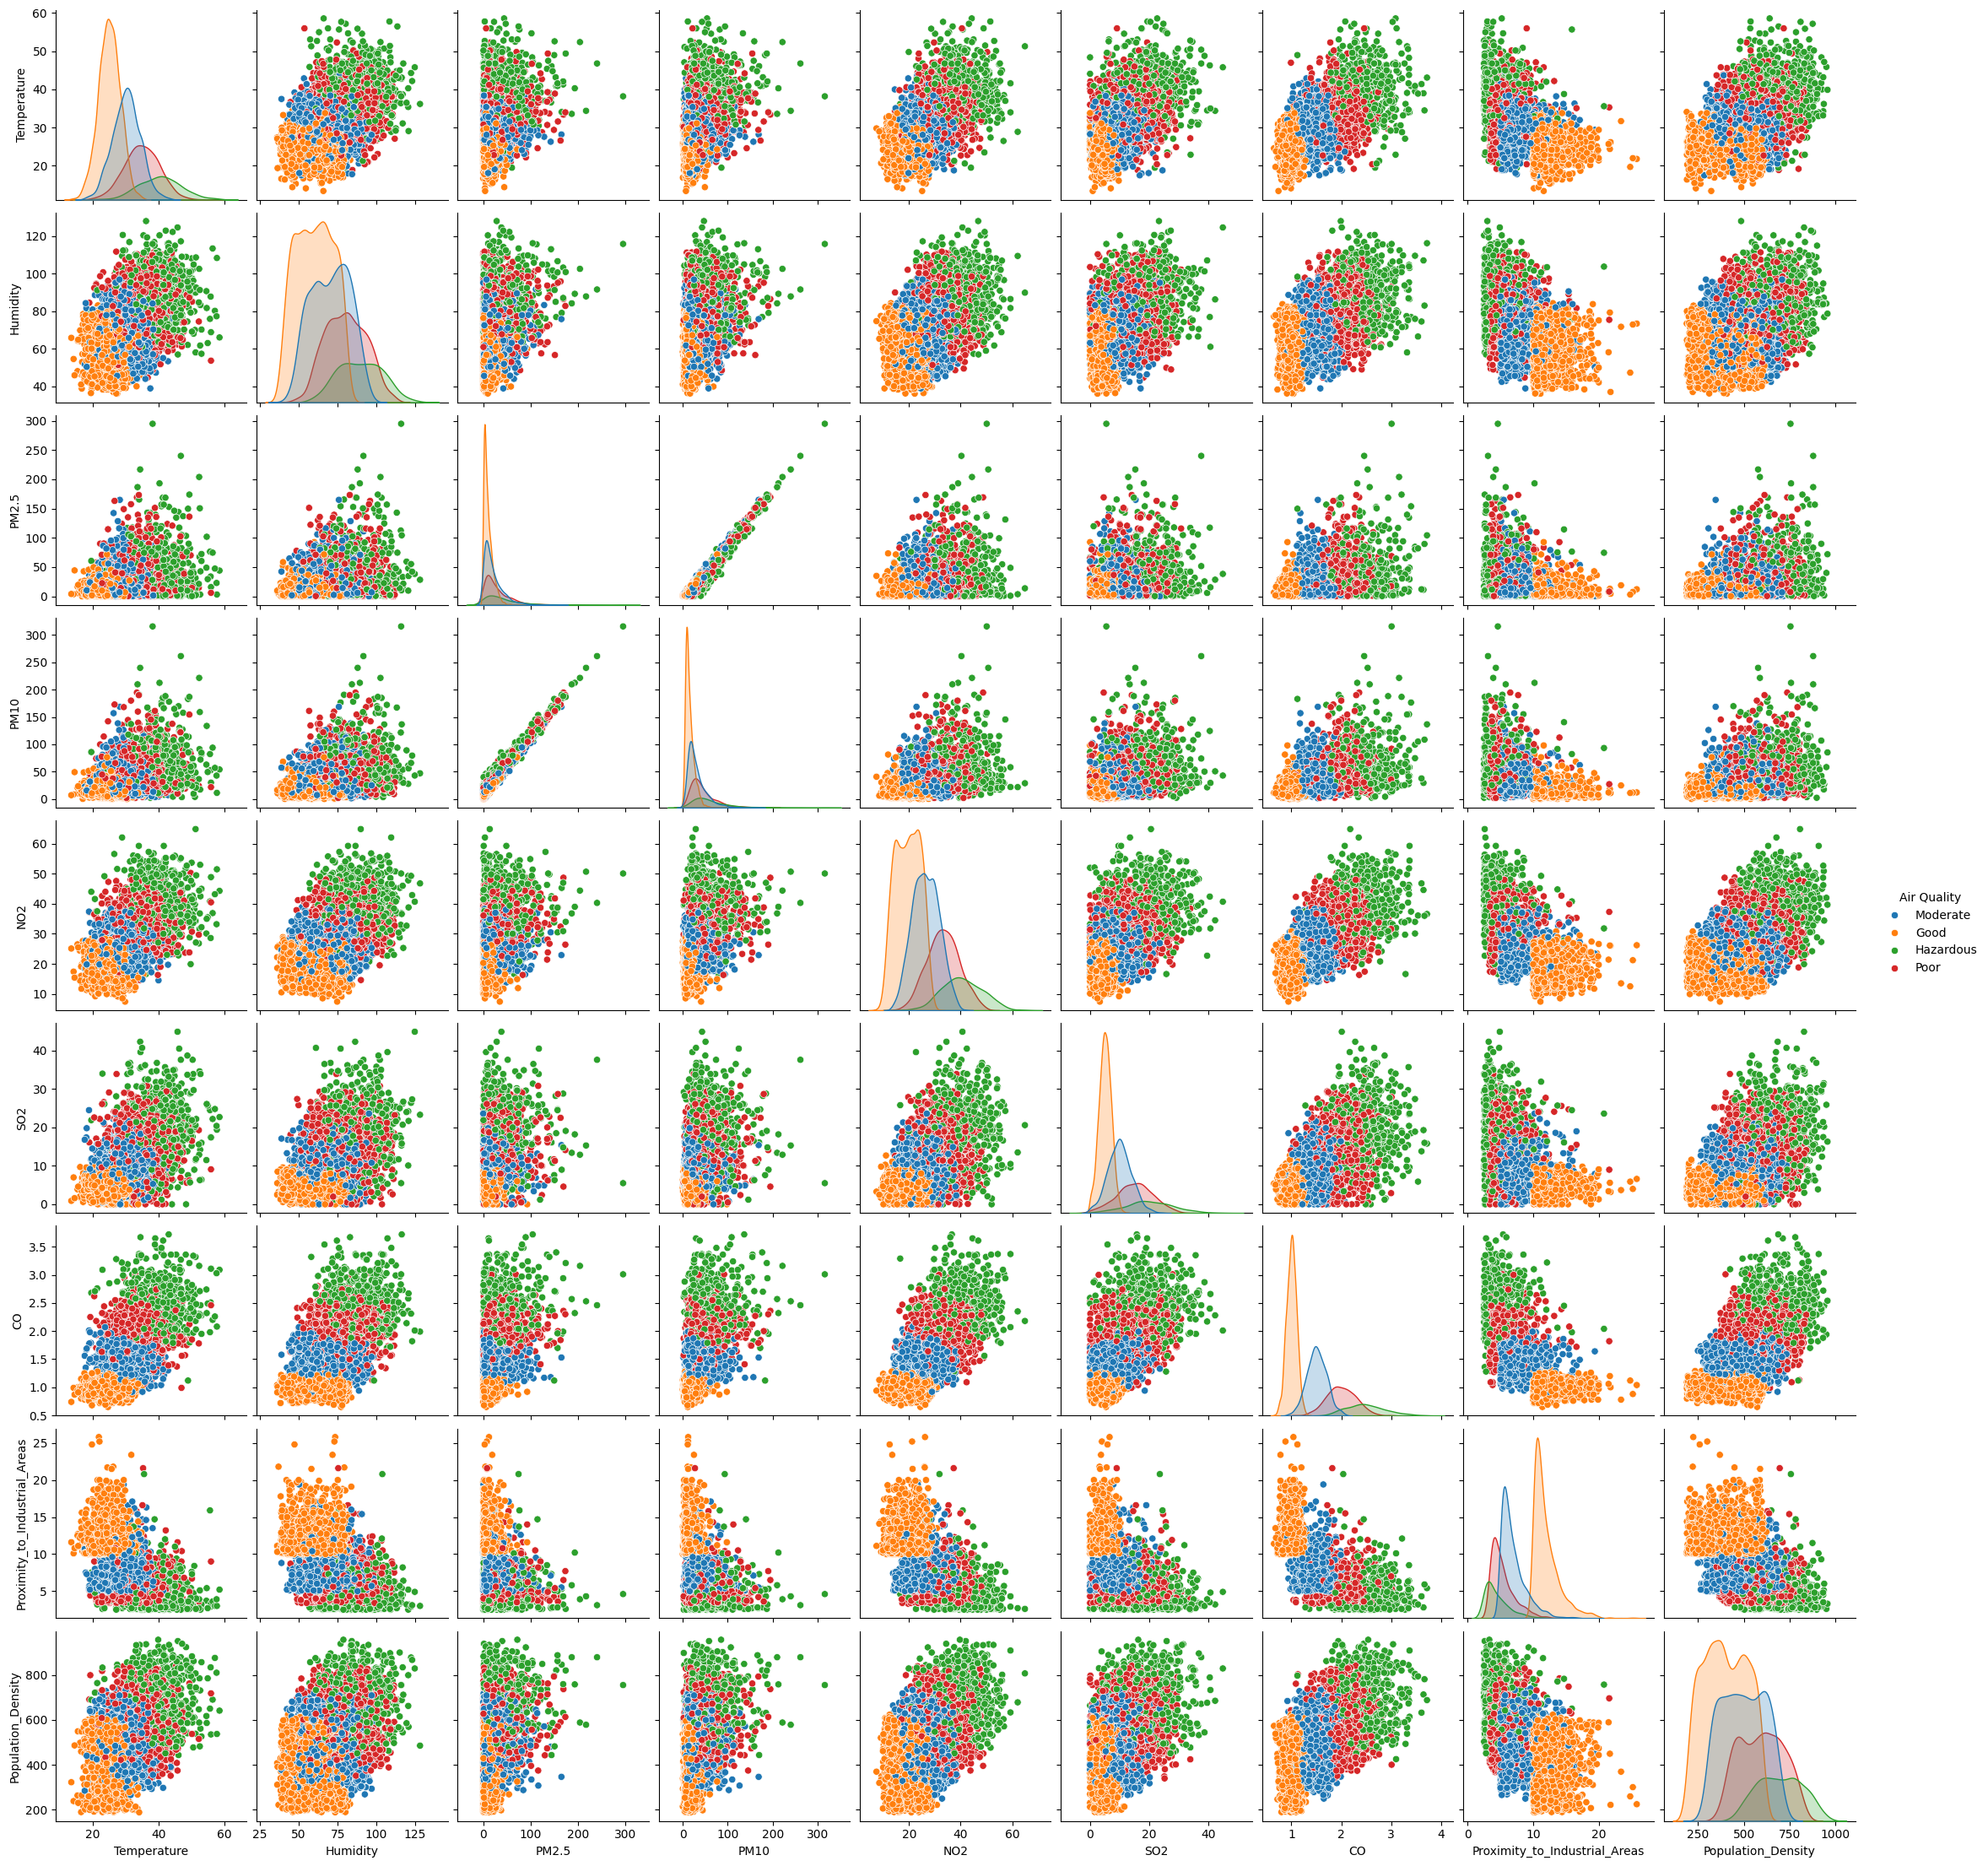

In [9]:
# pary
plt.figure(figsize=(10,10), dpi= 80)
sns.pairplot(data=data, kind="scatter", hue="Air Quality")

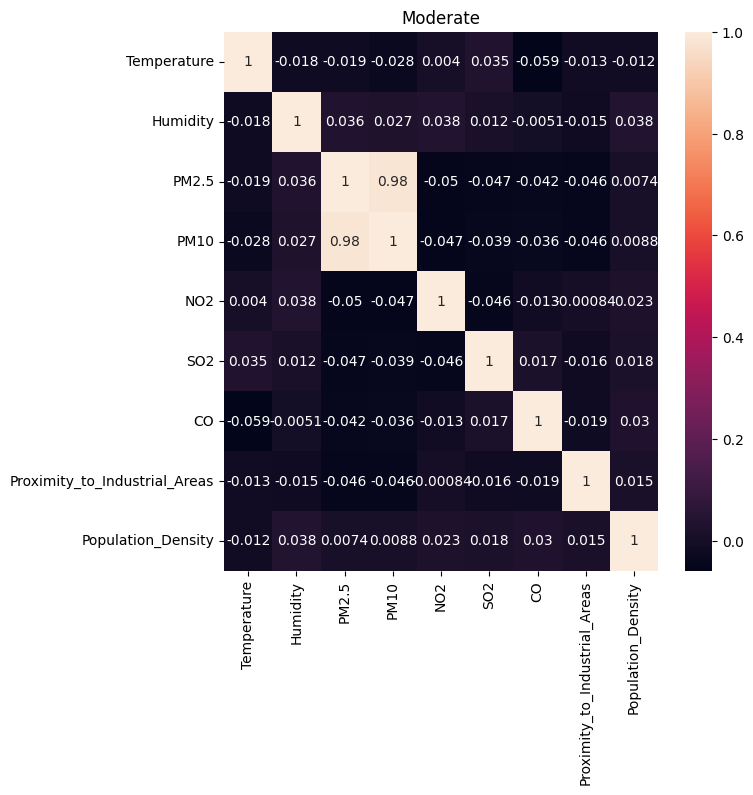

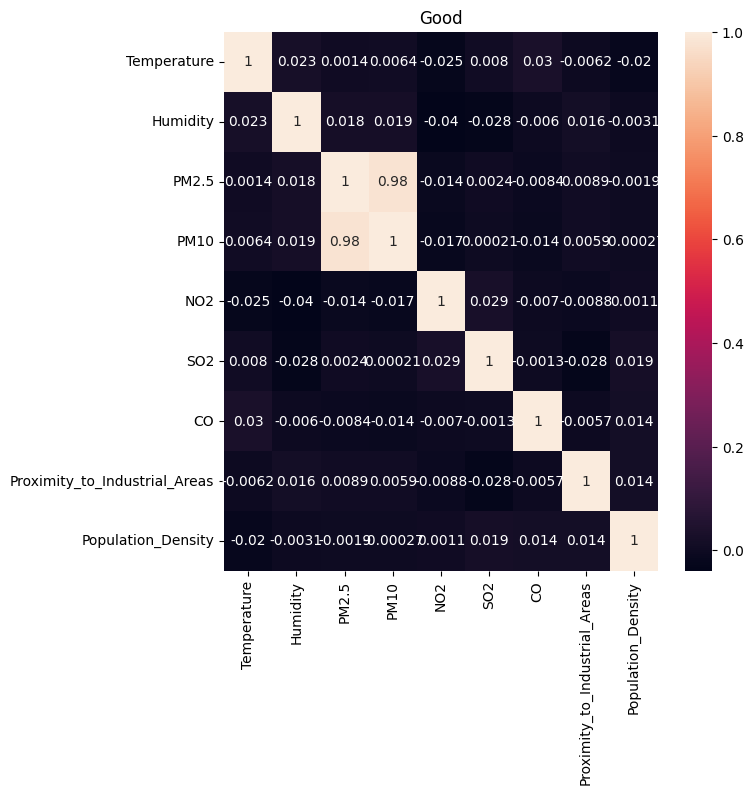

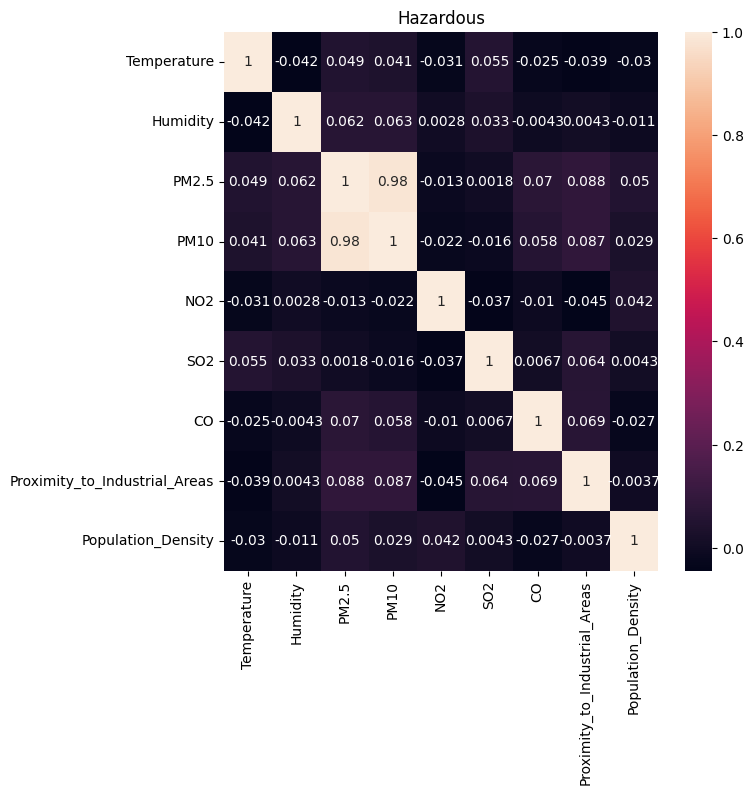

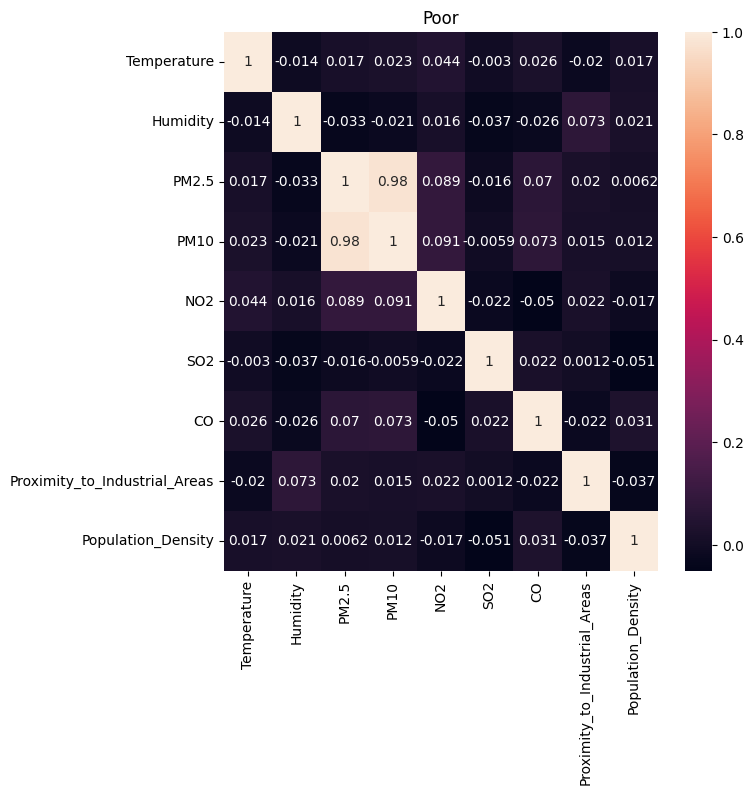

In [10]:
for k in data["Air Quality"].unique():
    plt.figure(figsize=(7,7))
    plt.title(k)
    tempDf = data[ data["Air Quality"] == k ].iloc[:,:-1]
    tempDf = tempDf.corr()
    sns.heatmap(tempDf,annot = tempDf)
    

#### Analiza Pairplota
Atrybuty PM10 i PM2.5 są bardzo silnie skorelowane co oznacza że duże natężenie jedych cząstek może wskazywać na występowanie drugich. Wnioskować z tego można że reprezentują one ten sam atrybut.

W obrębie jednej klasy nie wystempuje jakakolwiek korelacja (za wyłączeniem PM10 i PM2.5).\
Przy braku korelacji między danymi klasyfikator Bayesa powinien się dobrze sprawdzić

## Klasyfikacja

In [11]:
# pozbycie się jedego atrybutu ponieważ PM2.5 i PM10 są prawie jednym atrybutem
data = data.drop("PM2.5",axis=1)

In [12]:
# data[-1] to klasa
def testModel(data, model):
    data_test, data_lern = train_test_split(data, test_size=0.7)
    
    model.fit(data_lern.iloc[:,:-1], data_lern.iloc[:,-1])
    print( ", ".join( data.columns[:-1].tolist() ) )
    print("dokladnosc: ", end="")
    print(model.score(data_test.iloc[:,:-1], data_test.iloc[:,-1]))
    # error = pd.crosstab(data_test.iloc[:,-1] , model.predict(data_test.iloc[:,:-1]))
    # plt.figure(figsize=(4,4), dpi= 80)
    # sns.heatmap(error, annot = error)

# atybuty wybrane na bazie drzewa klasyfikacyjnego
def testDlaPartu(df, model):
    testModel(df.loc[:,["CO","Air Quality"]], model)
    testModel(df.loc[:,["CO", "Proximity_to_Industrial_Areas","Air Quality"]], model)
    testModel(df.loc[:,["CO", "Proximity_to_Industrial_Areas","Temperature","Air Quality"]], model)
    testModel(df.loc[:,["CO", "Proximity_to_Industrial_Areas","SO2","Air Quality"]], model)
    testModel(df.loc[:,["CO", "Proximity_to_Industrial_Areas","NO2","Air Quality"]], model)

In [13]:
# standaryzacja
dataRaw = data.iloc[:,:-1]
dataNormal = (dataRaw - dataRaw.mean())/dataRaw.std()
dataNormal["Air Quality"] = data["Air Quality"]

### Drzewo decyzyjne
Wybraliśmy drzewo decyzyjne, ponieważ przy analizie wykresów pudełkowych mogliśymy zaobserwować wyraźne granice miedzy klasami dla dużej ilości atrybutów. Dla takich przypadków drzewa decyzyjne dobrze się sprawdzają

Temperature, Humidity, PM10, NO2, SO2, CO, Proximity_to_Industrial_Areas, Population_Density
dokladnosc: 0.9173333333333333
Temperature, Humidity, PM10, NO2, SO2, CO, Proximity_to_Industrial_Areas, Population_Density
dokladnosc: 0.8893333333333333
|--- CO <= -0.58
|   |--- Proximity_to_Industrial_Areas <= 0.34
|   |   |--- Population_Density <= 0.95
|   |   |   |--- weights: [0.00, 0.00, 49.00, 0.00] class: Moderate
|   |   |--- Population_Density >  0.95
|   |   |   |--- weights: [0.00, 1.00, 4.00, 3.00] class: Moderate
|   |--- Proximity_to_Industrial_Areas >  0.34
|   |   |--- Temperature <= 0.51
|   |   |   |--- weights: [1374.00, 0.00, 0.00, 0.00] class: Good
|   |   |--- Temperature >  0.51
|   |   |   |--- Population_Density <= -0.55
|   |   |   |   |--- weights: [6.00, 0.00, 0.00, 0.00] class: Good
|   |   |   |--- Population_Density >  -0.55
|   |   |   |   |--- weights: [3.00, 0.00, 2.00, 0.00] class: Good
|--- CO >  -0.58
|   |--- CO <= 0.52
|   |   |--- Proximity_to_Industr

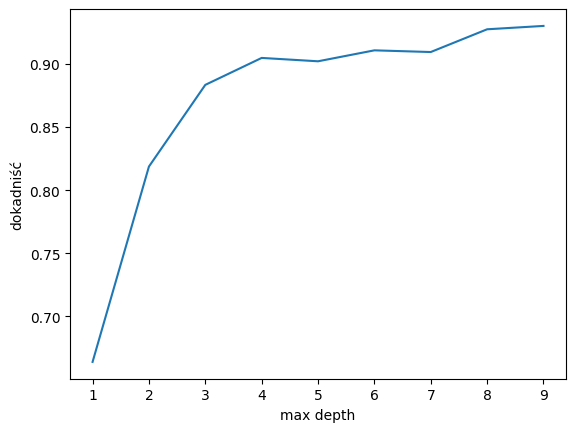

In [14]:
# sprawdzanie najlepszego max_depth
data_test, data_lern = train_test_split(data, test_size=0.7)
wynik = pd.Series()
for maxDepth in range(1, 10):
    model = DecisionTreeClassifier(max_depth = maxDepth, min_samples_leaf=5)
    model.fit(data_lern.iloc[:,:-1], data_lern.iloc[:,-1])
    wynik[maxDepth] = model.score(data_test.iloc[:,:-1], data_test.iloc[:,-1])
plt.xlabel("max depth")
plt.ylabel("dokadniść")
wynik.plot()

from sklearn.tree import plot_tree
import sklearn.tree as tree

model = DecisionTreeClassifier(max_depth = 4, min_samples_leaf=5)
testModel(data, model)
testModel(dataNormal, model)

# plt.figure(figsize=(20,10))
# plot_tree(model, feature_names=data.columns, class_names=data["Air Quality"].unique())
# plt.show()

text_representation = tree.export_text(model, feature_names=data.columns[:-1], show_weights=True)
print(text_representation)


#### Wnioski do drzewa decyzyjnego
Drzewo decyzyjne dobrze sobie radzi z klasyfikacją jakości powietrza z poprawnosćą ok 90%\
Dobrą maksysmalna głębokością dla której większej poprawych dokładności nie widzymy to głębokość 4, większe głebokości mogą prowadzić do przeuczenia\
Przy wizualizacji tego drzewa widzimy że naistotniejszymi atrybutami są *CO* i *Proximity_to_Industrial_Areas*.
Nie została równiesz zobserwowana poprawa po znormalizowaniu danych

### Klasyfikator Bayesa
Założenie klasyfikatora Bayesa, że atrybuty są od siebie niezależne pokrywa się z zaobserwowanym stanem rozkładu danych

In [15]:
# testowanie klasyfikatora Bayesa
model = GaussianNB()
testModel(data, model)
testModel(dataNormal, model)

Temperature, Humidity, PM10, NO2, SO2, CO, Proximity_to_Industrial_Areas, Population_Density
dokladnosc: 0.94
Temperature, Humidity, PM10, NO2, SO2, CO, Proximity_to_Industrial_Areas, Population_Density
dokladnosc: 0.942


In [16]:
testDlaPartu(data, model)
print()
testDlaPartu(dataNormal, model)

CO
dokladnosc: 0.8533333333333334
CO, Proximity_to_Industrial_Areas
dokladnosc: 0.8773333333333333
CO, Proximity_to_Industrial_Areas, Temperature
dokladnosc: 0.8733333333333333
CO, Proximity_to_Industrial_Areas, SO2
dokladnosc: 0.8986666666666666
CO, Proximity_to_Industrial_Areas, NO2
dokladnosc: 0.9073333333333333

CO
dokladnosc: 0.8273333333333334
CO, Proximity_to_Industrial_Areas
dokladnosc: 0.8686666666666667
CO, Proximity_to_Industrial_Areas, Temperature
dokladnosc: 0.888
CO, Proximity_to_Industrial_Areas, SO2
dokladnosc: 0.9006666666666666
CO, Proximity_to_Industrial_Areas, NO2
dokladnosc: 0.8966666666666666


#### Wnioski do klasyfikator Bayesa
Klasyfikator Bayesa radzi sobie wyjątkowo dobrze przy dokładności około 92%. Same współczynnik CO daje bardzo dużą dokładność, a korzystanie z tylko 3 atrybutów pozwala osiągnąć praktycznie taką samą dokładność co korzystanie ze wszystkich atrybutów. Nie została równiesz zobserwowana poprawa po znormalizowaniu danych.

### Model Najbliższego Centroidu
Większość atrybutów nie jest ze sobą skorelowana, a ich wykresy przyjmują rozkład normalny co sprzyja modelowi Najbliższego Centroidu.

In [17]:
model = NearestCentroid()
print("nie ustandaryzowane dane")
testModel(data, model)
print("ustandaryzowane dane")
testModel(dataNormal, model)

nie ustandaryzowane dane
Temperature, Humidity, PM10, NO2, SO2, CO, Proximity_to_Industrial_Areas, Population_Density
dokladnosc: 0.43933333333333335
ustandaryzowane dane
Temperature, Humidity, PM10, NO2, SO2, CO, Proximity_to_Industrial_Areas, Population_Density
dokladnosc: 0.9153333333333333


In [18]:
testDlaPartu(dataNormal, model)

CO
dokladnosc: 0.8226666666666667
CO, Proximity_to_Industrial_Areas
dokladnosc: 0.8593333333333333
CO, Proximity_to_Industrial_Areas, Temperature
dokladnosc: 0.862
CO, Proximity_to_Industrial_Areas, SO2
dokladnosc: 0.846
CO, Proximity_to_Industrial_Areas, NO2
dokladnosc: 0.8673333333333333


#### Wnioski do modelu Najbliższego Cetroidu
Bardzo łatwo można zauważyć, że bez ustandaryzowania danych dokładność jest nieproporcjonalnie mniejsza niż po ustandaryzowaniu, gdzie osiąga ona aż 91%. Drastyczna poprawa spowodowane jest faktem, że attrybuty posiadają różne skale swoich danych co sprawia, że niektóre atrybuty nieproporcjonalnie wpływają na wynik klasyfikacji. Tak jak w klasyfikatorze Bayesa tylko 3 atrybuty wystarczają aby osiągnąć dokładność mocno zbliżoną do korzystania ze wszystkich atrybutów.

## Wnioski
Każdy z przetestowanych modeli dobrze się sprawdza w klasyfikacji jakości powietrza.\
Z analizy wyników modeli wynika że do poprawnej klasyfikacji wystarczą trzy atrybuty: CO, Proximity_to_Industrial_Areas i NO2.